# Method of moments

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
import dsci345 as dsci

rng = np.random.default_rng(seed=123)

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}}$$
This is here so we can use `\P` and `\E` and `\var` and `\sd` in LaTeX below.

# Fitting distributions to data

In [2]:
lam = 1
npanels = 1000
nd = rng.poisson(lam * rng.exponential(size=npanels), size=npanels)
defects = pd.DataFrame({ "value" : np.arange(11, dtype='int') })
defects['observed'] = [np.sum(nd == k) for k in defects['value']]

## Back to the factory

In our Poisson example,
we had data like this
for the distribution of numbers of defects per solar panel.
Our goal was to get a good model for this number.
How did we do that?

In [3]:
defects

,value,observed
0,0,514
1,1,252
2,2,127
3,3,53
4,4,26
5,5,17
6,6,4
7,7,2
8,8,2
9,9,3


Well, here's what we did:

> The mean number of defects per panel is 1, and they're "counts", so... maybe Poisson? With mean 1?


In other words, we used the *Method of Moments*:

1. Pick a particular form of the distribution.
2. Choose parameter values for the distribution so that the "moments" (here, the mean) match.

Our next step was to say

> Gee, it's more spread out ("overdispersed") than that... maybe an Exponential mixture of Poissons?
>  (i.e., Poisson but where the mean is random, from the Exponential distribution)

Let's have a look at applying the method of moments here, too.

## Goodness-of-fit

*Do these look similar? How or how not?*

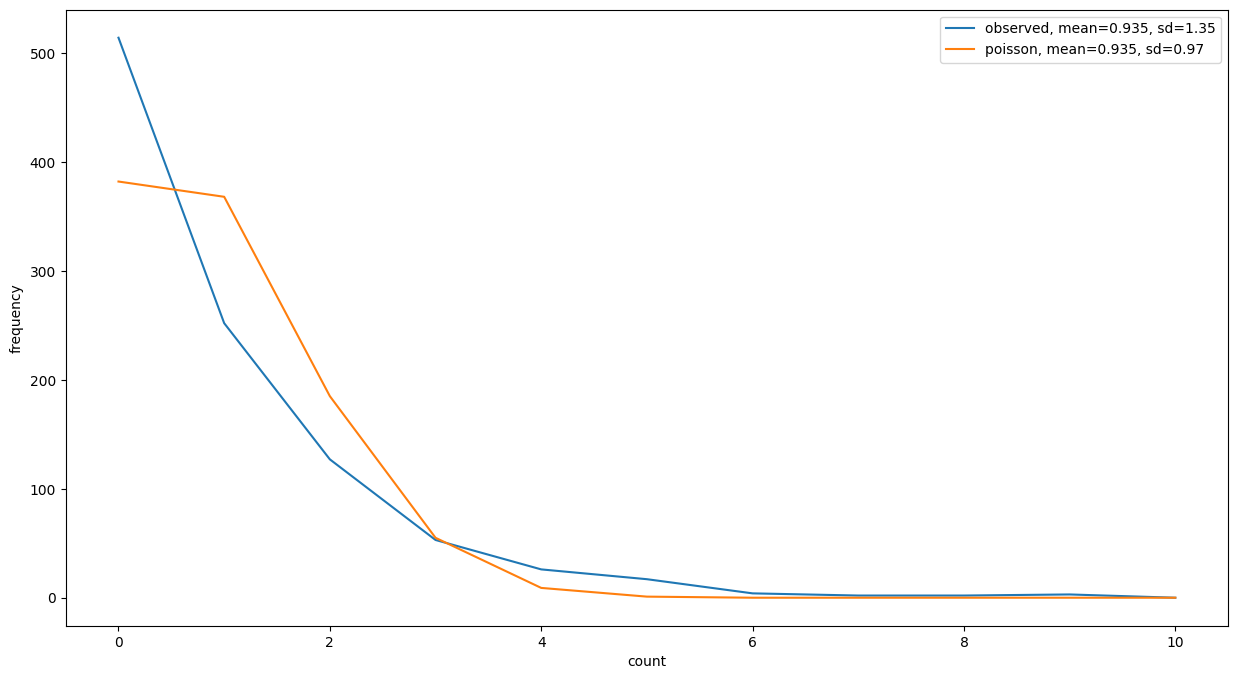

In [4]:
obs_mean = np.sum(defects['value'] * defects['observed']) / np.sum(defects['observed'])
obs_sd = np.sqrt(
    np.sum((defects['value'] ** 2) * defects['observed']) / np.sum(defects['observed'])
    - obs_mean ** 2
)
x = rng.poisson(obs_mean, size=np.sum(defects['observed']))
x_counts = [np.sum(x==u) for u in defects['value']]
plt.plot(defects['value'], defects['observed'], label=f'observed, mean={obs_mean}, sd={obs_sd:.2f}')
plt.xlabel("count"); plt.ylabel("frequency")
plt.plot(defects['value'], x_counts, label=f'poisson, mean={obs_mean}, sd={np.sqrt(obs_mean):.2f}')
plt.legend();

## Variance of a mixture

We'd like to fit *two* moments (mean and SD),
so let's use a model with *two* parameters:
$$\begin{aligned}
\text{error rate: } R &\sim \text{Gamma}(\text{scale}=\theta, \text{shape}=k) \\
\text{number of defects: } X &\sim \text{Poisson}(R) .
\end{aligned}$$
We'd like to see if we can choose $\theta$ and $k$ so the mean and SD match the observed values.

**Law of Total Variance:**
$$  \var[X] = \E[\var[X|R]] + \var[\E[X|R]] $$

Here we have
$$\begin{aligned}
   \var[X|R] &= R \\
   \E[X|R] &= R \\
   \E[R] &= \theta k \\
   \var[R] &= \theta^2 k
\end{aligned}$$
and so
$$ \var[X] = \theta k (1 + \theta ) , $$
i.e., the variance is *inflated* by $(1 + \theta)$.

Okay, so we want to find $\theta$ and $k$ so that
$$\begin{aligned}
  \E[X] = \E[R] = \theta k = \text{observed mean} \\
  \sd[X] = \sqrt{\theta k (1 + \theta)} = \text{observed SD} .
\end{aligned}$$

In [6]:
obs_mean, obs_sd

(0.935, 1.3478779618348242)

In [5]:
theta = obs_sd**2  / obs_mean - 1
k = obs_mean / theta
print(f"Estimates: theta = {theta:.2f}, k = {k:.2f}.")

Estimates: theta = 0.94, k = 0.99.


## Goodness-of-fit, take 2

Here's our fit, having used the *method of moments* to fit a *Gamma-Poisson mixture* to the data:

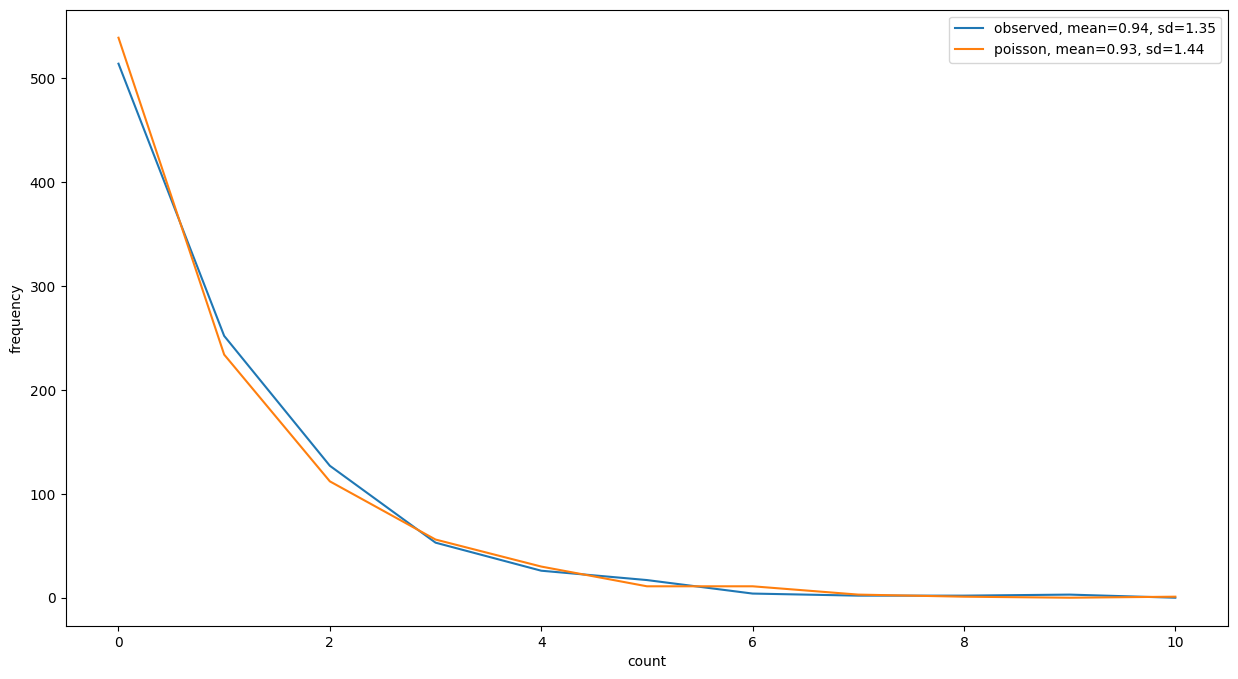

In [7]:
R = rng.gamma(shape=k, scale=theta, size=np.sum(defects['observed']))
X = rng.poisson(R, size=np.sum(defects['observed']))
X_counts = [np.sum(X==u) for u in defects['value']]
plt.plot(defects['value'], defects['observed'], label=f'observed, mean={obs_mean:.2f}, sd={obs_sd:.2f}')
plt.xlabel("count"); plt.ylabel("frequency")
plt.plot(defects['value'], X_counts, label=f'poisson, mean={np.mean(X):.2f}, sd={np.std(X):.2f}')
plt.legend();

## In class

In [13]:
k = 2
theta = 3
n = 1000
T = rng.gamma(scale=theta, shape=k, size=n)

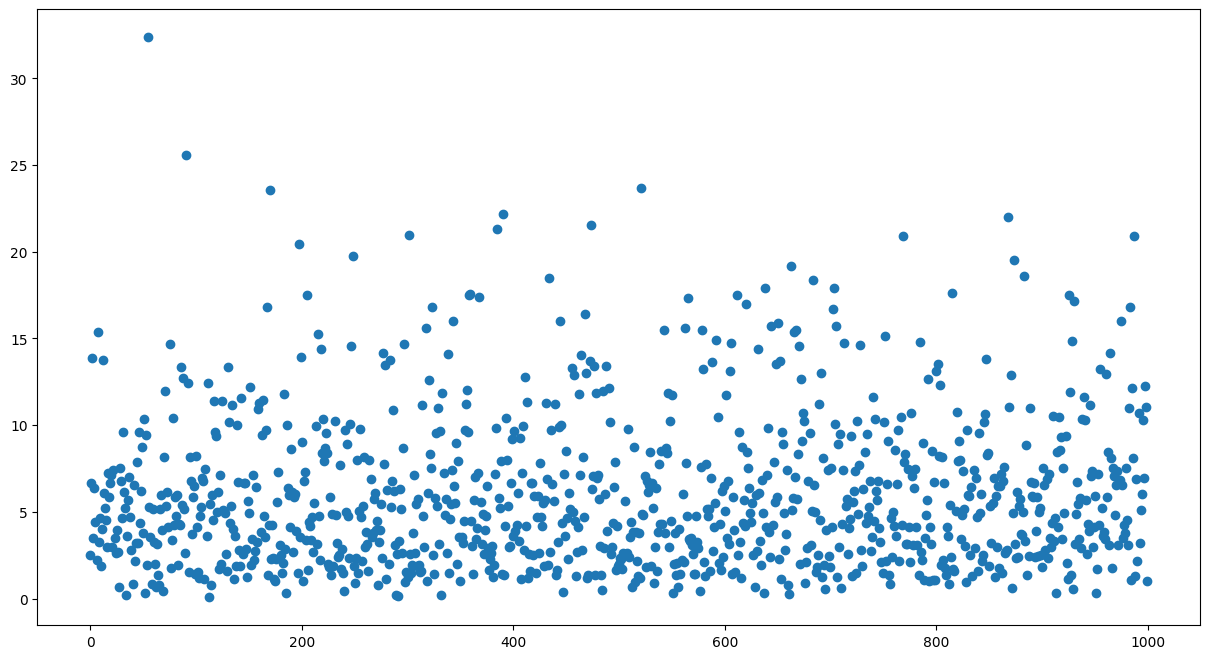

In [14]:
fig, ax = plt.subplots()
ax.scatter(np.arange(n), T)

In [15]:
np.mean(T), np.std(T)

(6.025761549468023, 4.451008125908613)

(array([ 36.,  89.,  90., 110.,  79.,  89.,  75.,  72.,  72.,  46.,  35.,
         35.,  31.,  21.,  19.,  13.,  20.,  10.,  12.,  11.,   6.,   9.,
          5.,   1.,   2.,   4.,   2.,   2.,   0.,   2.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.07354685,  0.88095431,  1.68836177,  2.49576924,  3.3031767 ,
         4.11058416,  4.91799162,  5.72539908,  6.53280654,  7.340214  ,
         8.14762146,  8.95502893,  9.76243639, 10.56984385, 11.37725131,
        12.18465877, 12.99206623, 13.79947369, 14.60688115, 15.41428862,
        16.22169608, 17.02910354, 17.836511  , 18.64391846, 19.45132592,
        20.25873338, 21.06614084, 21.87354831, 22.68095577, 23.48836323,
        24.29577069, 25.10317815, 25.91058561, 26.71799307, 27.52540054,
        28.332808  , 29.14021546, 29.94762292, 30.75503038, 31.56243784,
        32.3698453 ]),
 <BarContainer object of 40 artists>)

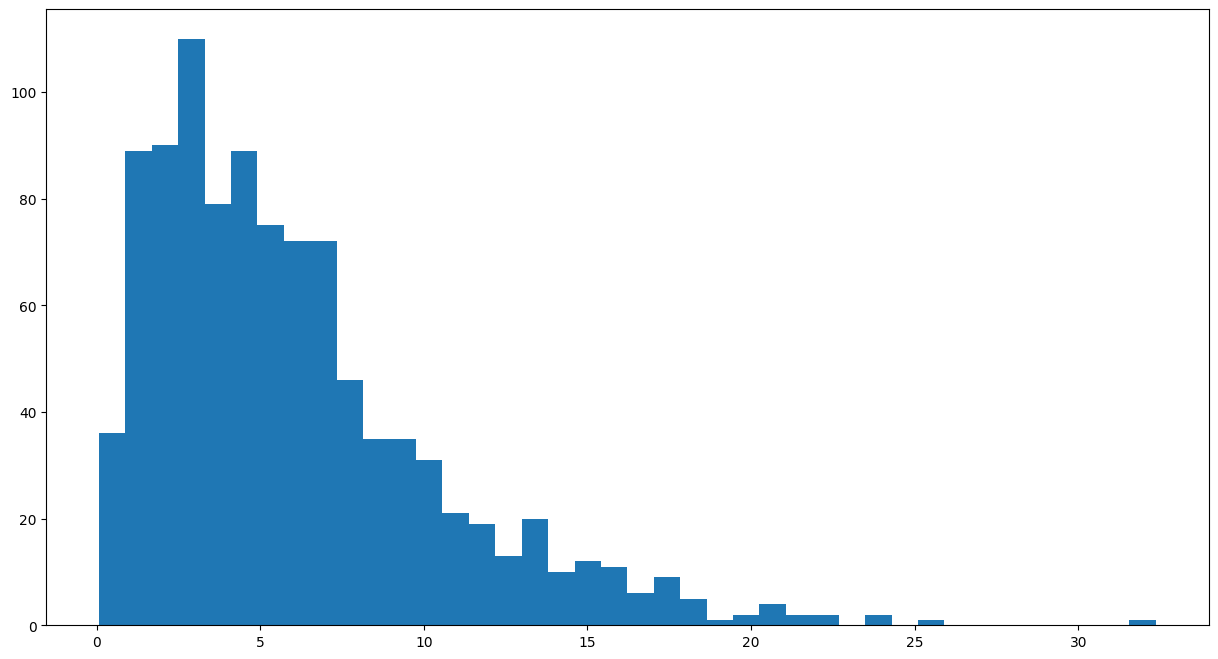

In [19]:
fig, ax = plt.subplots()
ax.hist(T, bins=40)